In [1]:
import torch
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


# Loading Yelp Review Dataset for Sentiment classification from Text

In [3]:
train_data=  pd.read_csv('train.tsv',sep='\t')
train_data = train_data[:1000]
val_data =  pd.read_csv('val.tsv',sep='\t')
val_data = val_data[:500]
def data_preprocessing(text):
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
pd.options.display.max_colwidth = 1000
train_data.head(5) #contents column has text data and rating column has multi-class sentiment 

,content,rating
0,"There are some restaurants that you don't want to tell others about because it's so great and if it becomes too popular you'll never get in. Well this is one and even though it's been open for a long time, I still feel like I don't want to rave about it too much because I'll never be able to get in again. I love the food and the ambiance here. We ate and enjoyed everything. Kale salad, beets...who knew those could actually taste so good you want to order seconds or thirds. The other screaming must have was a mushrooms dish (I know...but trust me it was almost orgasmic). Orichette was out of this world. Topped it off..we had a wonderful wine and desserts are yummy. We had the olive oil cake and a walnut dessert which were awesome. It's got great vibes, great food and it's a pure joy.",4star
1,Lucky for us there was no wait unlike other times I've seen a line out the door. We went on a weekend in the late afternoon. The pizza tasted so fresh and did not take too long. Service was good. We all thought the black olives were a bit more bitter than we are used to but probably because they are not canned. I would go again.,4star
2,"Worst ever Michelin restaurant I have ever been to. There was a Bread and butter counted as a course, as well as a fried onion as a main course. Never go this restaurant again.",1star
3,"Came here today to celebrate my birthdays with my parents and husband in the dining room. I had a pleasant overall experience. The service was great. I was just a bit underwhelmed by the food (not sure if I just had too high expectations because of the stellar reviews). Overall I would give Gramercy Tavern 4.5 stars for service and 3 stars for food. The four of us ordered the seasonal tasting menu. We had the marinated fluke, lobster salad, hake, spinach tortellini, pasture raised beef, and blueberry. Honestly, the meal was quite unmemorable. All the dishes were cooked well but nothing really stuck out. I think my favorite dish of the night was the hake (which was slightly over salted). My favorite bites were the maitake mushrooms which was served with the spinach tortellini and the complimentary black sesame chocolate truffle (so good)!! The beef was tender but not very flavorful. The spinach tortellini was good but not memorable. Overall, I did have a pleasant experience. The ser...",4star
4,"This, is where hipsters go to get Caribbean food. Gentrification is a hell of a thing. A few short blocks over on Nostrand, the scene is COMPLETELY different, but I guess Glady's is a sign of the change creeping slowly across this once Caribbean neighborhood. There's kitschy island tunes playing in the background, and your Jamaican fare is served up in a safe, hipster-friendly manner. Let's not mince words here... the food is straight up bland. The rice and peas looked like a plate of white rice with about 3 peas in it. A Jamaican grandmother rolled over in her grave when that was brought out to me. The jerk chicken, while it tasted okay, felt like it was just reheated from last night. Ditto for the plantains. And the ackee and saltfish was just tasteless. An entire generation of Jamaican grandmothers rolled over with that one. Oye... perhaps they were having an off day. I was here for brunch, and was thoroughly disappointed by the experience. The two stars are for the am...",2star


In [5]:
train_data.rating.value_counts(normalize=True) #balanced target classes

1star    0.212
5star    0.203
3star    0.197
2star    0.195
4star    0.193
Name: rating, dtype: float64

In [6]:
# !pip install transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

C:\Users\Jayathilaga\miniconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# Text Preprocessing

In [7]:
MAX_LEN = 300 # restricted to 300 tokens due to memory constraints
def bert_preprocessing(data):
    input_ids = []
    attention_masks = []
    for i in data:
        encoded_input = tokenizer.encode_plus(text=data_preprocessing(i),add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True,return_attention_mask=True)
        input_ids.append(encoded_input.get('input_ids'))
        attention_masks.append(encoded_input.get('attention_mask'))
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    return input_ids, attention_masks

In [8]:
train_inputs, train_masks = bert_preprocessing(train_data.content)
val_inputs, val_masks = bert_preprocessing(val_data.content)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Jayathilaga\miniconda3\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(train_data.rating)
y_val= encoder.transform(val_data.rating)

In [10]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
batch_size = 4

train_x = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_x)
train_dataloader = DataLoader(train_x, sampler=train_sampler, batch_size=batch_size)

val_x = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_x)
val_dataloader = DataLoader(val_x, sampler=val_sampler, batch_size=batch_size)

# Fine Tuning BERT for multi class text classification

In [11]:
import torch.nn as nn
from transformers import BertModel

class Classifier_For_Bert(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Classifier_For_Bert, self).__init__()
        input, hidden, output = 768, 150, 5
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(input, hidden),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, hidden),
            nn.Dropout(0.3),
            nn.Linear(hidden, output)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)        
        hs = outputs[0][:, 0, :]
        logits = self.classifier(hs)
        return logits

In [12]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    bertClassifier = Classifier_For_Bert(freeze_bert=False)
    bertClassifier.to(device)
    optimizer = AdamW(bertClassifier.parameters(),lr=5e-5,eps=1e-8)
    steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)
    return bertClassifier, optimizer, scheduler

In [13]:
import random
import time
import gc
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=124):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    print("Training...\n")
    for i in range(epochs):
        time_taken = time.time()
        total_loss,batch_loss = 0,0
        count = 0
        model.train()
        print(f"Epoch = {i+1}")
        for step, batch in enumerate(train_dataloader):
            count += 1
            time_taken, time_epoch = 0,0
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            del b_input_ids
            del b_attn_mask
            gc.collect()
            torch.cuda.empty_cache()
            loss = loss_fn(logits, b_labels.type(torch.int64).to(device))
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - time_taken
                print(f"step:  {step}, batch loss: {batch_loss / count}, time taken:  {time_elapsed}")
                batch_loss, count = 0, 0
                time_taken = time.time()
        time_elapsed = time.time() - time_epoch
        avg_train_loss = total_loss / len(train_dataloader)
        val_loss, val_accuracy = evaluate(model, val_dataloader)
        torch.save(model.state_dict(), "sentiment_model_"+str(i+1))
        print(f"Epoch = {i+1}, Train_loss = {avg_train_loss}, Time taken: {time_elapsed},\n\t Validation loss = {val_loss}, Validation accuracy: {val_accuracy}")    
    print("model saved")

In [14]:
def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels.type(torch.int64).to(device))
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

# Model Training

In [15]:
gc.collect()
torch.cuda.empty_cache()

bertClassifier, optimizer, scheduler = initialize_model(epochs=10)
train(bertClassifier, train_dataloader, val_dataloader, epochs=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Jayathilaga\miniconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be r

Training...

Epoch = 1
step:  100, batch loss: 1.5712116342960019, time taken:  1685822525.2885852
step:  200, batch loss: 1.407916122674942, time taken:  1685822624.8639753
step:  249, batch loss: 1.1824569252072548, time taken:  1685822673.9704385
Epoch = 1, Train_loss = 1.4296975066661834, Time taken: 1685822673.9714599,
	 Validation loss = 1.107772696018219, Validation accuracy: 52.8
Epoch = 2
step:  100, batch loss: 1.0762032385509792, time taken:  1685822806.3130512
step:  200, batch loss: 0.9835787114500999, time taken:  1685822906.079861
step:  249, batch loss: 1.0927864191483478, time taken:  1685822954.9409628
Epoch = 2, Train_loss = 1.042403731107712, Time taken: 1685822954.9422545,
	 Validation loss = 1.0845439903736114, Validation accuracy: 53.0
Epoch = 3
step:  100, batch loss: 0.8836461400041485, time taken:  1685823087.384557
step:  200, batch loss: 0.7188356766104698, time taken:  1685823186.994913
step:  249, batch loss: 0.7369441359627004, time taken:  1685823235.919

In [20]:
import torch.nn.functional as F
def predict(model, test_dataloader):
    model.eval()
    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        preds = torch.argmax(logits, dim=1).flatten()
        all_logits.append(preds.tolist())
    pred = [j for i in all_logits for j in i]
    return pred
y_pred = predict(bertClassifier, val_dataloader)

# Multi class Evaluation 

In [21]:
from sklearn.metrics import classification_report
sentiment = encoder.classes_
print(classification_report(y_pred, y_val, target_names=sentiment))

              precision    recall  f1-score   support

       1star       0.64      0.80      0.71        75
       2star       0.67      0.52      0.59       131
       3star       0.55      0.50      0.53       101
       4star       0.59      0.58      0.58       123
       5star       0.52      0.67      0.58        70

    accuracy                           0.59       500
   macro avg       0.59      0.61      0.60       500
weighted avg       0.60      0.59      0.59       500



# Model Architecture 

In [22]:
model = Classifier_For_Bert(freeze_bert=False)
model.load_state_dict(torch.load("sentiment_model_4"))
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classifier_For_Bert(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

## Inference
1. The review text can be changed to any input text field of our choice.
2. Model is stored in sentiment_model_4 file. Which is being used in the inference code to predict new reviews sentiment.
3. There are 5 sentiments ranked from 1-5, 1 being frustrated or unhappy and 5 being the happy and satisfied. 

In [23]:
review_text = '''The worse I would say. While I was reading the menu the server took the menu away. The Afghani chicken was uncooked in the center, when I got it to the notice of the server she said that's the set oven temperature and that's how it is made and did nothing about it. I'm attaching pictures for others to see how pathetic the service recovery can be. I mean we're paying for our meal. Not eating for free right? No water was offered during the course of our dine in. The manager, please be mindful of the people you hire. Thanks. Wouldn't visit again or recommend to anyone!'''
input_ids,attention_mask = bert_preprocessing([review_text])

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1).flatten()

print(f'Reviews: {review_text}')
print(f'Sentiment  : {sentiment[prediction]}')

C:\Users\Jayathilaga\miniconda3\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Reviews: The worse I would say. While I was reading the menu the server took the menu away. The Afghani chicken was uncooked in the center, when I got it to the notice of the server she said that's the set oven temperature and that's how it is made and did nothing about it. I'm attaching pictures for others to see how pathetic the service recovery can be. I mean we're paying for our meal. Not eating for free right? No water was offered during the course of our dine in. The manager, please be mindful of the people you hire. Thanks. Wouldn't visit again or recommend to anyone!
Sentiment  : 1star


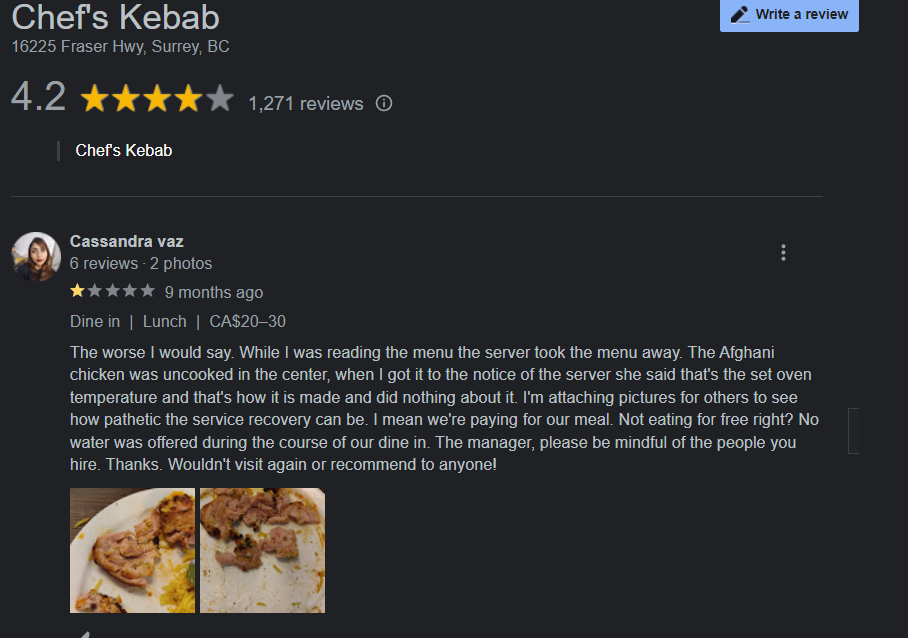